# Executing Job on Pasqal hardware

In [76]:
import numpy as np
from qat.core import Schedule, Variable
from qat.core.variables import heaviside

Simulation on Pasqal hardware and simulation software can be performed using [Pulser](https://pulser.readthedocs.io/). This notebook first presents how to generate a `Job` that can be executed on Pasqal hardware, before showing how to execute it using Pasqal hardware. 

## Generating a Job to execute on Pasqal hardware

In [77]:
from pulser import Pulse, Sequence, Register
from pulser.waveforms import CustomWaveform
from pulser.devices import MockDevice, AnalogDevice
from pulser_myqlm import IsingAQPU
from pulser_myqlm.myqlmtools import are_equivalent_schedules

On Pulser we can solve problems of shape 
$$ H = \hbar \sum_i \frac{\Omega(t)}{2}(\cos(\phi) \sigma_i^x - \sin(\phi) \sigma_i^y) - \frac{\delta(t)}{2}\sigma_i^z + \frac{1}{2}\sum_{i\neq j}U_{ij}n_i n_j$$
with $\sigma_i^x$, $\sigma_i^y$, $\sigma_i^z$ the Pauli operators $X$, $Y$, $Z$ applied on qubit $i$ and $n_i = \frac{1+\sigma_i^z}{2}$.

This Hamiltonian is named the <u>Ising Hamiltonian</u>. It is composed of a time-independent part, $\frac{1}{2}\sum_{i\neq j}U_{ij}n_i n_j$, and the rest of the terms that make a time-dependent Hamiltonian. In Pulser, this Hamiltonian is generated via a `Sequence` object. It is initialized by a `Device` and a `Register` that define the coefficients $U_{ij}$. Then, `Pulse`s are added to this `Sequence` to generate the time-dependent terms of this Hamiltonian. You can find more information about this Ising Hamiltonian in the [Pulser documentation](https://pulser.readthedocs.io/en/stable/review.html).  

The [pulser-myqlm package](https://github.com/pasqal-io/Pulser-myQLM) and its `IsingAQPU` class enables you to either generate such an Ising Hamiltonian in a MyQLM `Schedule` or `Job` step-by-step, or to convert a Pulser Sequence into a MyQLM `Schedule` or `Job` directly. We will introduce the two methods in the next two sections. 

### Step-by-step creation of MyQLM Schedule and Job using IsingAQPU

#### Defining an IsingAQPU

On Pulser, any simulation starts by defining a `Device` and a `Register`. Any `IsingAQPU` should be defined by these two objects. It can also be defined by a `Sequence` directly, this is explained in the next section.

`IsingAQPU` describes a specific AQPU on which only pulses applied on a `Rydberg.Global` channel can be run. This generates the Ising Hamiltonian described above. 

Let's start by creating a device having a `Rydberg.Global` channel, and a square register of 2x2 atoms spaced by $5\mu m$. The `MockDevice` defines a device for simulations on which all channels are implemented.



In [78]:
device = MockDevice
register = Register.square(2, 5, None)
aqpu = IsingAQPU(device, register)

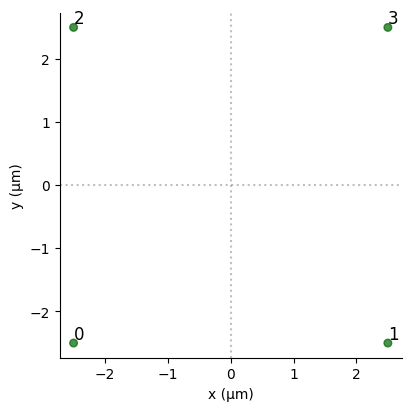

In [79]:
# You can see the register used by the qpu
aqpu.register.draw()

This `IsingAQPU` defines the interaction matrix between each atom, described by the matrix $U_{ij}$ in the Ising Hamiltonian. This interaction matrix can be accessed via the property `c6_interactions` of the `IsingAQPU`. 

In [80]:
# Check qpu properties
print(
    "Distances (in um):\n", aqpu.distances, "\n"
)  # symetric matrix, for each qubit two qubits are at 4um distance and one at 4 * sqrt(2) um
print("Interactions (in rad/us):\n", aqpu.c6_interactions)  # Interaction matrix U_{ij}

Distances (in um):
 [[0.         5.         5.         7.07106781]
 [5.         0.         7.07106781 5.        ]
 [5.         7.07106781 0.         5.        ]
 [7.07106781 5.         5.         0.        ]] 

Interactions (in rad/us):
 [[  0.         346.89014592 346.89014592  43.36126824]
 [346.89014592   0.          43.36126824 346.89014592]
 [346.89014592  43.36126824   0.         346.89014592]
 [ 43.36126824 346.89014592 346.89014592   0.        ]]


#### Generating time-dependent Ising Hamiltonians

In the Ising Hamiltonian, the parameters of the time-dependent part of the Hamiltonian are $\Omega$, $\delta$ and $\phi$. They are the amplitude, detuning and phase of a `Pulse` in Pulser. The amplitude and the detuning can be time-dependent, whereas the phase is constant. Let's start by defining time-dependent amplitude and detuning:

In [95]:
t_variable = Variable("t")  # in ns
u_variable = Variable("u")  # parameter
omega_t = t_variable / 100  # in rad/us
delta_t = (1 - t_variable + u_variable) / 100  # in rad/us

We can then compute the Ising Hamiltonians associated to pulses defined by $\Omega$, $\delta$, $\phi$ using `IsingAQPU.hamiltonian`.

- Here is an Hamiltonian associated with a pulse of constant amplitude $\Omega=1rad/\mu s$, zero detuning and phase.
It is equivalent to apply a X gate on each qubit, and ZZ gates whose coefficients are defined from the Van der Waals interactions between the atoms.

In [96]:
t1 = 100  # in ns
H1 = aqpu.hamiltonian(1, 0, 0)  # omega(t)=1, delta(t)=0, phi=0
print(H1)  # in rad/us

368.57078004000005 * I^4 +
0.5 * (X|[0]) +
0.5 * (X|[1]) +
0.5 * (X|[2]) +
0.5 * (X|[3]) +
86.72253648 * (ZZ|[1, 0]) +
86.72253648 * (ZZ|[2, 0]) +
10.840317059999999 * (ZZ|[2, 1]) +
10.840317059999999 * (ZZ|[3, 0]) +
86.72253648 * (ZZ|[3, 1]) +
86.72253648 * (ZZ|[3, 2]) +
184.28539002 * (Z|[0]) +
184.28539002000002 * (Z|[1]) +
184.28539002000002 * (Z|[2]) +
184.28539002000002 * (Z|[3])


- If now the phase is equal to $\pi / 2$, we no longer add a X gate on each qubit but a Y gate.

In [97]:
t2 = 100  # in ns
H2 = aqpu.hamiltonian(1, 0, np.pi / 2)  # omega(t)=1, delta(t)=0, phi=pi/2
print(H2)  # in rad/us

368.57078004000005 * I^4 +
-0.5 * (Y|[0]) +
-0.5 * (Y|[1]) +
-0.5 * (Y|[2]) +
-0.5 * (Y|[3]) +
86.72253648 * (ZZ|[1, 0]) +
86.72253648 * (ZZ|[2, 0]) +
10.840317059999999 * (ZZ|[2, 1]) +
10.840317059999999 * (ZZ|[3, 0]) +
86.72253648 * (ZZ|[3, 1]) +
86.72253648 * (ZZ|[3, 2]) +
184.28539002 * (Z|[0]) +
184.28539002000002 * (Z|[1]) +
184.28539002000002 * (Z|[2]) +
184.28539002000002 * (Z|[3])


- It is also possible to define time-dependent pulses, varying in amplitude and detuning. See that the coefficients in front the ZZ operators are unchanged.

In [98]:
t0 = 100  # in ns
H0 = aqpu.hamiltonian(omega_t, delta_t, 0)  # omega(t)=omega_t, delta(t)=delta_t, phi=0
print(H0)  # in rad/us

368.57078004000005 * I^4 +
((t / 100) / 2.0) * (X|[0]) +
((t / 100) / 2.0) * (X|[1]) +
((t / 100) / 2.0) * (X|[2]) +
((t / 100) / 2.0) * (X|[3]) +
86.72253648 * (ZZ|[1, 0]) +
86.72253648 * (ZZ|[2, 0]) +
10.840317059999999 * (ZZ|[2, 1]) +
10.840317059999999 * (ZZ|[3, 0]) +
86.72253648 * (ZZ|[3, 1]) +
86.72253648 * (ZZ|[3, 2]) +
(184.28539002 + (-((((1 - t) + u) / 100)) / 2.0)) * (Z|[0]) +
(184.28539002000002 + (-((((1 - t) + u) / 100)) / 2.0)) * (Z|[1]) +
(184.28539002000002 + (-((((1 - t) + u) / 100)) / 2.0)) * (Z|[2]) +
(184.28539002000002 + (-((((1 - t) + u) / 100)) / 2.0)) * (Z|[3])


Note that the output of `IsingAQPU.hamiltonian` is an Hamiltonian in $rad/\mu s$. It has to be multiplied by $\hbar$ to be in energy units.

#### Making a Schedule and a Job of Ising Hamiltonians

The Hamiltonian is implemented as the drive of a `Schedule` object. You also have to define the duration of the evolution of this `Schedule` object. In Pulser, the duration of Pulses are defined as integers in nanoseconds.

A `Schedule` can be implemented on the `IsingAQPU` if the coefficients in front of the ZZ operators match the Van der Waals interactions. Therefore, when using hamiltonians defined with `IsingAQPU`, the sum of the drive coefficients should be equal to 1 along the duration of the `Schedule`.

In [99]:
schedule0 = Schedule(drive=[(1, H0)], tmax=t0)
schedule1 = Schedule(drive=[(1, H1)], tmax=t1)
schedule2 = Schedule(drive=[(1, H2)], tmax=t2)

In [100]:
schedule = schedule0 | schedule1 | schedule2
print(schedule)

drive:
(heaviside(t,0,200) * heaviside(t,0,100)) * 368.57078004000005 * I^4 +
((t / 100) / 2.0) * (X|[0]) +
((t / 100) / 2.0) * (X|[1]) +
((t / 100) / 2.0) * (X|[2]) +
((t / 100) / 2.0) * (X|[3]) +
86.72253648 * (ZZ|[1, 0]) +
86.72253648 * (ZZ|[2, 0]) +
10.840317059999999 * (ZZ|[2, 1]) +
10.840317059999999 * (ZZ|[3, 0]) +
86.72253648 * (ZZ|[3, 1]) +
86.72253648 * (ZZ|[3, 2]) +
(184.28539002 + (-((((1 - t) + u) / 100)) / 2.0)) * (Z|[0]) +
(184.28539002000002 + (-((((1 - t) + u) / 100)) / 2.0)) * (Z|[1]) +
(184.28539002000002 + (-((((1 - t) + u) / 100)) / 2.0)) * (Z|[2]) +
(184.28539002000002 + (-((((1 - t) + u) / 100)) / 2.0)) * (Z|[3])
(heaviside(t,0,200) * heaviside(t,100,200)) * 368.57078004000005 * I^4 +
0.5 * (X|[0]) +
0.5 * (X|[1]) +
0.5 * (X|[2]) +
0.5 * (X|[3]) +
86.72253648 * (ZZ|[1, 0]) +
86.72253648 * (ZZ|[2, 0]) +
10.840317059999999 * (ZZ|[2, 1]) +
10.840317059999999 * (ZZ|[3, 0]) +
86.72253648 * (ZZ|[3, 1]) +
86.72253648 * (ZZ|[3, 2]) +
184.28539002 * (Z|[0]) +
184.28539002

Here is an equivalent definition of the former `Schedule`, using `heaviside` explicitly instead of temporal compositions.

In [101]:
schedule_sum = Schedule(
    drive=[
        [heaviside(t_variable, 0, t0), H0],
        [heaviside(t_variable, t0, t1 + t0), H1],
        [heaviside(t_variable, t1 + t0, t1 + t0 + t2), H2],
    ],
    tmax=t1 + t0 + t2,
)
print(schedule_sum)

drive:
heaviside(t,0,100) * 368.57078004000005 * I^4 +
((t / 100) / 2.0) * (X|[0]) +
((t / 100) / 2.0) * (X|[1]) +
((t / 100) / 2.0) * (X|[2]) +
((t / 100) / 2.0) * (X|[3]) +
86.72253648 * (ZZ|[1, 0]) +
86.72253648 * (ZZ|[2, 0]) +
10.840317059999999 * (ZZ|[2, 1]) +
10.840317059999999 * (ZZ|[3, 0]) +
86.72253648 * (ZZ|[3, 1]) +
86.72253648 * (ZZ|[3, 2]) +
(184.28539002 + (-((((1 - t) + u) / 100)) / 2.0)) * (Z|[0]) +
(184.28539002000002 + (-((((1 - t) + u) / 100)) / 2.0)) * (Z|[1]) +
(184.28539002000002 + (-((((1 - t) + u) / 100)) / 2.0)) * (Z|[2]) +
(184.28539002000002 + (-((((1 - t) + u) / 100)) / 2.0)) * (Z|[3])
heaviside(t,100,200) * 368.57078004000005 * I^4 +
0.5 * (X|[0]) +
0.5 * (X|[1]) +
0.5 * (X|[2]) +
0.5 * (X|[3]) +
86.72253648 * (ZZ|[1, 0]) +
86.72253648 * (ZZ|[2, 0]) +
10.840317059999999 * (ZZ|[2, 1]) +
10.840317059999999 * (ZZ|[3, 0]) +
86.72253648 * (ZZ|[3, 1]) +
86.72253648 * (ZZ|[3, 2]) +
184.28539002 * (Z|[0]) +
184.28539002000002 * (Z|[1]) +
184.28539002000002 * (Z|[2]

In [102]:
are_equivalent_schedules(schedule, schedule_sum)

True

A `Job` can be created from a `Schedule` via the `to_job` method. Read more regarding this method [in the MyQLM documentation](https://myqlm.github.io/04_api_reference/module_qat/module_core/schedule.html#qat.core.Schedule.to_job).

### Converting a Pulser Sequence into a Schedule or Job

The class method `from_sequence` of `IsingAQPU` creates an `IsingAQPU` instance having directly the `Register` and `Device` of the `Sequence`.

The class methods `IsingAQPU.convert_sequence_to_schedule` and `IsingAQPU.convert_sequence_to_job` also performs the direct conversion from a `Sequence` to a `Schedule` or `Job`. 

For instance, the `Schedule` could have also been built from a Pulser `Sequence` by adding the pulses described above.

In [103]:
seq = Sequence(register, device)
seq.declare_channel("ryd_glob", "rydberg_global")
seq.add(
    Pulse(
        CustomWaveform([omega_t(t=ti) for ti in range(t0)]),
        CustomWaveform(
            [delta_t(t=ti, u=0) for ti in range(t0)]
        ),  # no parametrized sequence for the moment
        0,
    ),
    "ryd_glob",
)  # corresponds to H0
seq.add(Pulse.ConstantPulse(t1, 1, 0, 0), "ryd_glob")  # corresponds to H1
seq.add(Pulse.ConstantPulse(t2, 1, 0, np.pi / 2), "ryd_glob")  # corresponds to H2

In [104]:
schedule_from_seq = IsingAQPU.convert_sequence_to_schedule(seq)

In [105]:
are_equivalent_schedules(schedule_from_seq, schedule(u=0))

True

The pulses of the `Sequence` are the instructions sent to the hardware. If you want a model of the behaviour of the hardware, you should convert while setting the `modulation` argument to `True`. You can learn more about modulation [in the Pulser documentation](https://pulser.readthedocs.io/en/stable/tutorials/output_mod_eom.html).

Here is an example with the device `AnalogDevice`, that models a real device with only a `Rydberg.Global` channel.

C:\Users\AntoineCORNILLOT\AppData\Local\Temp\ipykernel_23772\3961679037.py:2: UserWarning: Switching to a device with a different Rydberg level, check that the expected interactions still hold.
  analog_seq = seq.switch_device(AnalogDevice)


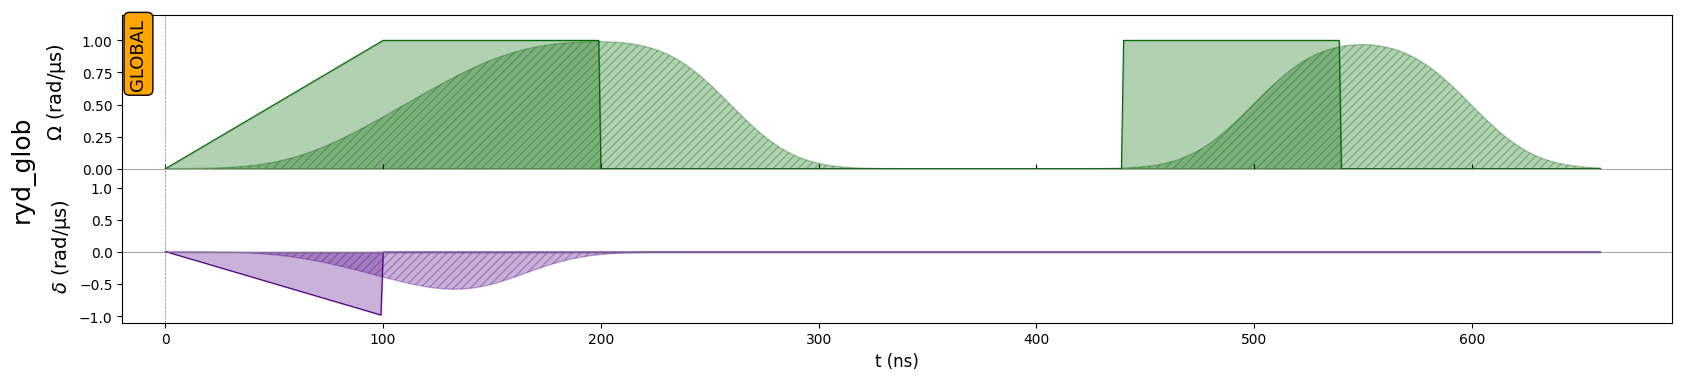

drive:
1 * ((get_item([0.005283597381893872, 0.004765372895744332, 0.004315107656678695, 0.003927990387293574, 0.0035996983157872042, 0.0033263839295578097, 0.003104661053788537, 0.0029315904694360417, 0.002804665259586223, 0.002721796047457271, 0.0026812962637856232, 0.002681867556282461, 0.002722585429591739, 0.002802885180990441, 0.002922548175179429, 0.0030816884811348234, 0.0032807398752625777, 0.0035204431981968706, 0.0038018340375747437, 0.004126230696102464, 0.004495222393248387, 0.004910657639970118, 0.0053746327190134354, 0.00588948019849372, 0.0064577574036343835, 0.0070822347706327934, 0.007765884007586642, 0.008511865990138635, 0.009323518323873453, 0.010204342511428951, 0.011157990669600572, 0.012188251750302045, 0.01329903722893607, 0.014494366234355212, 0.015778350105988274, 0.017155176375704982, 0.018629092184383616, 0.02020438715577301, 0.02188537576289553, 0.023676379234743774, 0.025581707063186482, 0.027605638181652636, 0.02975240189810683, 0.0320261586749175, 0.034

In [107]:
# Creating a Sequence from a real device
analog_seq = seq.switch_device(AnalogDevice)
analog_seq.draw()
# Samples of the Sequence are in full line, modulated samples in hatched
# mod_schedule_from_seq contains the modulated samples of the analog_seq
mod_schedule_from_seq = IsingAQPU.convert_sequence_to_schedule(analog_seq, True)
print(mod_schedule_from_seq)

It is also possible to convert the Pulser `Sequence` directly into a job using `IsingAQPU.convert_sequence_to_job`. You can define the number of shots of the job in the attribute `nbshots`. The default value asks for the maximum number of shots the device can take.

In [109]:
job_from_seq = IsingAQPU.convert_sequence_to_job(
    analog_seq, nbshots=1000, modulation=True
)
print(job_from_seq)

Job(circuit=None, schedule=Schedule(tname='t', drive_obs=[Observable(terms=[Term(_coeff=TNumber(is_abstract=True, type=None, int_p=None, double_p=None, string_p='* / get_item [0.005283597381893872,0.004765372895744332,0.004315107656678695,0.003927990387293574,0.0035996983157872042,0.0033263839295578097,0.003104661053788537,0.0029315904694360417,0.002804665259586223,0.002721796047457271,0.0026812962637856232,0.002681867556282461,0.002722585429591739,0.002802885180990441,0.002922548175179429,0.0030816884811348234,0.0032807398752625777,0.0035204431981968706,0.0038018340375747437,0.004126230696102464,0.004495222393248387,0.004910657639970118,0.0053746327190134354,0.00588948019849372,0.0064577574036343835,0.0070822347706327934,0.007765884007586642,0.008511865990138635,0.009323518323873453,0.010204342511428951,0.011157990669600572,0.012188251750302045,0.01329903722893607,0.014494366234355212,0.015778350105988274,0.017155176375704982,0.018629092184383616,0.02020438715577301,0.0218853757628955

## Simulating a Job on Pasqal hardware and simulation tools

Any `Job` implementing an Ising Hamiltonian can be simulated using a local or remote QPU of Qaptiva Access by using its `submit_job` method. The only condition on this QPU is that it must be able to simulate [Analog Jobs](https://myqlm.github.io/02_user_guide/01_write/02_analog_schedule/03_an_jobs.html).

A Job encapsulating a serialized Pulser `Sequence` under the key "abstr_dict" of the dictionary `Job.schedule._other` can be simulated using Pasqal hardware and simulation tools.

`IsingAQPU` has a `submit_job` method that can be used to simulate the sequence either using `pulser_simulation` or another qpu. To use `pulser_simulation`, simply set the QPU to `None`:

In [94]:
# Create an IsingAQPU
simulation_aqpu = IsingAQPU.from_sequence(analog_seq, qpu=None)
# Simulate the sequence
# If job was converted from the sequence using modulation=True,
# modulated samples of the sequence are used for the simulation
result = simulation_aqpu.submit_job(job_from_seq, n_samples=1000)
print(result)

Result(need_flip=False, lsb_first=False, nbqbits=None, has_statevector=False, statevector=None, data=None, _value=None, raw_data=[Sample(_amplitude=None, probability=0.9985, _state=0, err=None, intermediate_measurements=None, qregs=None), Sample(_amplitude=None, probability=0.001, _state=1, err=None, intermediate_measurements=None, qregs=None), Sample(_amplitude=None, probability=0.0005, _state=8, err=None, intermediate_measurements=None, qregs=None)], qregs=None, error=None, value_data=None, error_data=None, meta_data=None, in_memory=None, _parameter_map=None, _values=None, values_data=None)
